### 정규화 절단
| 장점                                | 단점                                 |
| --------------------------------- | ---------------------------------- |
| - 객체의 경계가 뚜렷하지 않아도 자연스럽게 영역 분할 가능 | - 계산 비용이 큼(대규모 그래프는 메모리/시간 많이 듬)   |
| - 작은 잡음이 잘려나가는 Min-Cut 문제 보완      | - 근사해라 완벽히 최적은 아님                  |
| - 의료 영상, 물체 인식, 텍스처 분할 등에서 활용     | - 큰 이미지 처리 시 SLIC(슈퍼픽셀)과 같이 전처리 필요 |

### 단계
| 단계                      | 설명                                   |
| ----------------------- | ------------------------------------ |
| **1)** 데이터 로드           | `skimage.data.coffee()`로 RGB 이미지 가져옴 |
| **2)** SLIC             | 픽셀 → 슈퍼픽셀로 그룹화해 노이즈 제거 & 연산 속도 개선    |
| **3)** RAG              | 인접 슈퍼픽셀 간 유사도를 그래프 형태로 표현            |
| **4)** Normalized Cut   | 그래프 분할로 영역 내부 유사도 최대, 경계 유사도 최소화     |
| **5)** mark\_boundaries | 분할된 영역 경계 시각화                        |
| **6)** OpenCV 출력        | BGR 변환해 OpenCV 창으로 보기                |

In [2]:
import skimage
import numpy as np
import cv2 as cv
import time
from skimage import graph  # 최신 버전에서는 skimage.future.graph 아님!

# [1] 샘플 이미지: 커피 사진 불러오기
coffee = skimage.data.coffee()

# [2] 시간 측정 시작
start = time.time()

# [3] SLIC Superpixel Segmentation
# compactness: 색상과 공간 거리의 균형
# n_segments: 슈퍼픽셀 개수
# start_label=1: 라벨링을 1부터 시작
slic = skimage.segmentation.slic(
    coffee, compactness=20, n_segments=600, start_label=1
)

# [4] RAG (Region Adjacency Graph) 생성
# rag_mean_color: 평균 색상 기반 가중치 계산
# mode='similarity': 픽셀 간 유사도로 가중치 설정
g = graph.rag_mean_color(coffee, slic, mode='similarity')

# [5] Normalized Cut (정규화 절단) 수행
# SLIC 슈퍼픽셀 라벨과 RAG 그래프를 이용해 그래프 컷
ncut = graph.cut_normalized(slic, g)

# [6] 처리 시간 출력
print(coffee.shape, 'Coffee 영상을 분할하는 데', time.time()-start, '초 소요')

# [7] 경계선 표시
marking = skimage.segmentation.mark_boundaries(coffee, ncut)

# [8] [0,1] float → [0,255] uint8로 변환 (OpenCV용)
ncut_coffee = np.uint8(marking * 255.0)

# [9] OpenCV로 결과 출력 (RGB → BGR)
cv.imshow('Normalized cut', cv.cvtColor(ncut_coffee, cv.COLOR_RGB2BGR))

cv.waitKey()          # 키 입력 대기
cv.destroyAllWindows() # 모든 창 닫기


(400, 600, 3) Coffee 영상을 분할하는 데 2.2229366302490234 초 소요


In [3]:
np.unique(ncut)

array([  1,   8,  35,  58,  70, 120, 147, 164, 169, 181, 232, 279, 300,
       315, 326, 336, 339, 348, 361, 375, 391, 394, 396, 400, 465, 471,
       526], dtype=int64)

In [4]:
np.unique(ncut).size

27

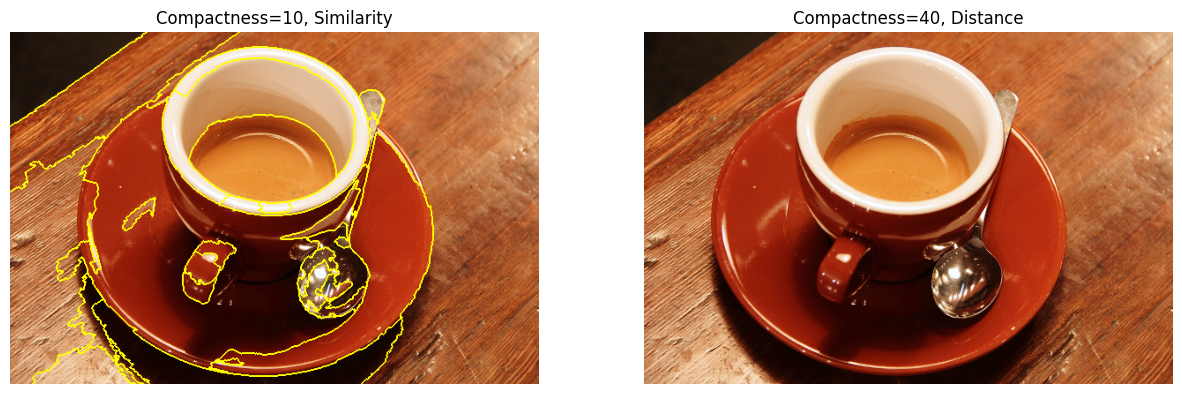

In [5]:
import skimage
import numpy as np
import cv2 as cv
from skimage import graph
import matplotlib.pyplot as plt

coffee = skimage.data.coffee()

# ---- 실험 1 ----
slic1 = skimage.segmentation.slic(
    coffee, compactness=10, n_segments=800, start_label=1
)
g1 = graph.rag_mean_color(coffee, slic1, mode='similarity')
ncut1 = graph.cut_normalized(slic1, g1)
mark1 = skimage.segmentation.mark_boundaries(coffee, ncut1)

# ---- 실험 2 ----
slic2 = skimage.segmentation.slic(
    coffee, compactness=40, n_segments=300, start_label=1
)
g2 = graph.rag_mean_color(coffee, slic2, mode='distance')
ncut2 = graph.cut_normalized(slic2, g2)
mark2 = skimage.segmentation.mark_boundaries(coffee, ncut2)

# ---- 시각화 ----
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(mark1)
ax[0].set_title('Compactness=10, Similarity')
ax[0].axis('off')

ax[1].imshow(mark2)
ax[1].set_title('Compactness=40, Distance')
ax[1].axis('off')

plt.show()


### SLIC 파라미터
| 파라미터          | 역할             | 실험 아이디어                      |
| ------------- | -------------- | ---------------------------- |
| `compactness` | 색상 vs 공간 거리 균형 | 값 ↑: 덩어리가 더 압축됨, 값 ↓: 색상에 민감 |
| `n_segments`  | 원하는 슈퍼픽셀 수     | 값 ↑: 더 세밀한 분할                |
| `start_label` | 라벨링 시작값        | 주로 1 추천 (0은 배경으로 인식될 수 있음)   |

### RAG 파라미터
| 파라미터             | 역할           | 실험 아이디어                        |
| ---------------- | ------------ | ------------------------------ |
| `mode`           | 가중치 계산 방식    | `'distance'` vs `'similarity'` |
| `rag_mean_color` | 평균 색상 기반 가중치 | 기본값은 `mode='distance'`         |